In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
import cv2

In [2]:
dataset_path = "/home/saydam/Desktop/2024-2025_itu/blg202/project/" #this path should include dataset1 and dataset2 folders , all code 
                                                                    #implemented condsidered this path


# Functions

In [3]:
def QR(A):
    """
    QR decompoisition
    Input A (n x m) matrix
    Output Q (n x n) and R (n x n) matrix 
    """
    n = A.shape[1]
    Q = np.zeros_like(A, dtype=float)
    R = np.zeros((n, n), dtype=float)

    for i in range(n):
        v = A[:, i]
        for j in range(i):
            R[j, i] = np.dot(Q[:, j], A[:, i])
            v = v - R[j, i] * Q[:, j]
        R[i, i] = np.linalg.norm(v)
        Q[:, i] = v / R[i, i]
    return Q, R

In [4]:
def calculate_eigval_eigvec(A, max_iter=1000, tol=1e-10):
    """
    Calculates eigenvalues and eigenvectors with QR method
    """
    n = A.shape[0]
    A_k = A.copy()
    Q_total = np.eye(n)

    for _ in range(max_iter):
        Q, R = QR(A_k)
        A_k = R @ Q
        Q_total = Q_total @ Q

        # stop condition check
        off_diagonal = A_k - np.diag(np.diag(A_k))
        if np.all(np.abs(off_diagonal) < tol):
            break

    eigvals = np.diag(A_k)
    eigvecs = Q_total
    return eigvals, eigvecs

In [5]:
def complete_orthonormal_columns(U):
    m, n = U.shape
    rank = np.linalg.matrix_rank(U)
    Q = []

    # normalize columns
    for i in range(n):
        col = U[:, i]
        norm = np.linalg.norm(col)
        if norm > 1e-10:
            Q.append(col / norm)

    #add new orthonormal vectors
    while len(Q) < m:
        new_vec = np.random.rand(m)
        for q in Q:
            new_vec -= np.dot(new_vec, q) * q
        norm = np.linalg.norm(new_vec)
        if norm > 1e-10:
            Q.append(new_vec / norm)

    return np.stack(Q, axis=1)

In [6]:
def SVD(A):

    #calculate eigenvalues and eigenvectors of A.T @ A
    A = np.array(A)
    ATA = A.T @ A
    eigval , eigvec = calculate_eigval_eigvec(ATA)

    #sorting eigenvalues and eigenvectors
    idx = np.argsort(eigval)[::-1]
    eigval = eigval[idx]
    eigvec = eigvec[:, idx]

    V = eigvec

    #singular values
    singular_values = np.sqrt(np.maximum(eigval, 0))

    #creating singular value matrix
    m, n = A.shape
    Sigma = np.zeros((m, n))
    for i in range(min(m, n)):
        Sigma[i, i] = singular_values[i]

    #calculating U matrix
    U = np.zeros((m, m))
    for i in range(len(singular_values)):
        if singular_values[i] > 1e-10:  #avoid zero dividing
            u_i = (1 / singular_values[i]) * A @ V[:, i]
            U[:, i] = u_i

        U = complete_orthonormal_columns(U)

    return U, Sigma, V.T   

In [7]:
def umeyama_alignment(src_points, dst_points):

    assert src_points.shape == dst_points.shape
    n, dim = src_points.shape

    # Ortalama merkezlerini al
    mu_src = np.mean(src_points, axis=0)
    mu_dst = np.mean(dst_points, axis=0)

    # Merkezlenmiş noktalar
    src_centered = src_points - mu_src
    dst_centered = dst_points - mu_dst

    # Kovaryans matrisi
    cov_matrix = dst_centered.T @ src_centered / n

    # SVD
    U, D, Vt = SVD(cov_matrix)
    
    R = U @ Vt
    if np.linalg.det(R) < 0:
        print("mirror detected")
        Vt[-1, : ] *= -1
        R = U @ Vt

    t = mu_dst - R @ mu_src

    return R, t

# PART A)

## 1)Bottle

In [8]:
mat1 = np.loadtxt(dataset_path + "dataset1/bottle/mat1.txt")
mat2 = np.loadtxt(dataset_path + "dataset1/bottle/mat2.txt")
correspondences = np.loadtxt(dataset_path + "dataset1/bottle/correspondences.txt").astype(int)

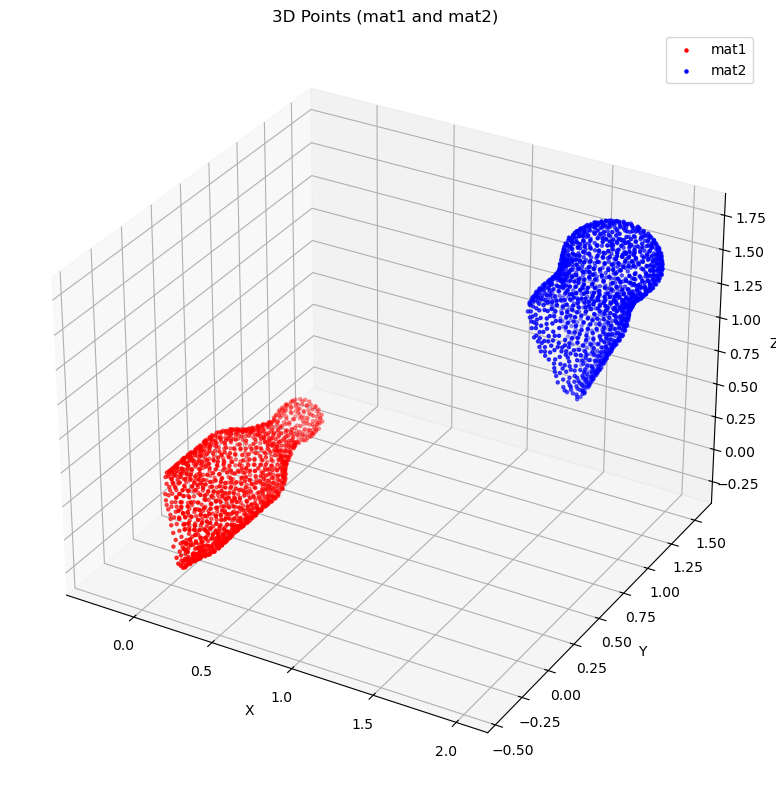

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(mat1[:, 0], mat1[:, 1],mat1[:, 2], color='red', label='mat1', s=5)

# mat2
ax.scatter(mat2[:, 0], mat2[:, 1], mat2[:, 2], color='blue', label='mat2', s=5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Points (mat1 and mat2)')
ax.legend()
plt.tight_layout()
plt.show()

In [10]:
matched_src = mat2[correspondences[:, 1]]  
matched_dst = mat1[correspondences[:, 0]]  


R, t = umeyama_alignment(matched_src, matched_dst)

mat2_aligned = ((R @ mat2.T)).T + t

In [11]:
print("Rotation Matrix:\n" , R)
print("Transition Matrix:\n" , t)

Rotation Matrix:
 [[-0.74685719 -0.56646155  0.34831832]
 [-0.38868107 -0.05314961 -0.91983811]
 [ 0.53956589 -0.82237245 -0.18047768]]
Transition Matrix:
 [1.48934185 1.59086101 0.37030048]


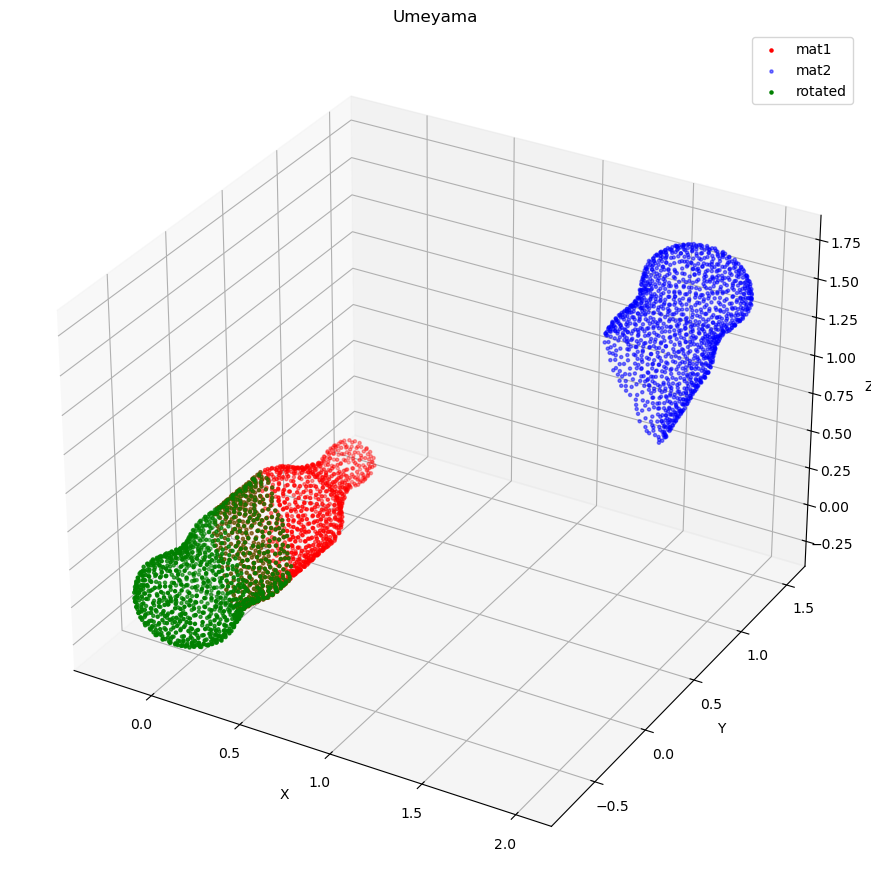

In [12]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Nokta bulutları
ax.scatter(mat1[:, 0], mat1[:, 1], mat1[:, 2], c='red', label='mat1', s=5)
ax.scatter(mat2[:, 0], mat2[:, 1], mat2[:, 2], c='blue', label='mat2', s=5, alpha=0.5)
ax.scatter(mat2_aligned[:, 0], mat2_aligned[:, 1], mat2_aligned[:, 2], c='green', label='rotated', s=5)

# Ekseni ayarla
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Umeyama')
ax.legend()
plt.tight_layout()
plt.show();

## 2)Chair

In [13]:
mat1 = np.loadtxt(dataset_path + "dataset1/chair/mat1.txt")
mat2 = np.loadtxt(dataset_path + "dataset1/chair/mat2.txt")
correspondences = np.loadtxt(dataset_path + "dataset1/chair/correspondences.txt").astype(int)

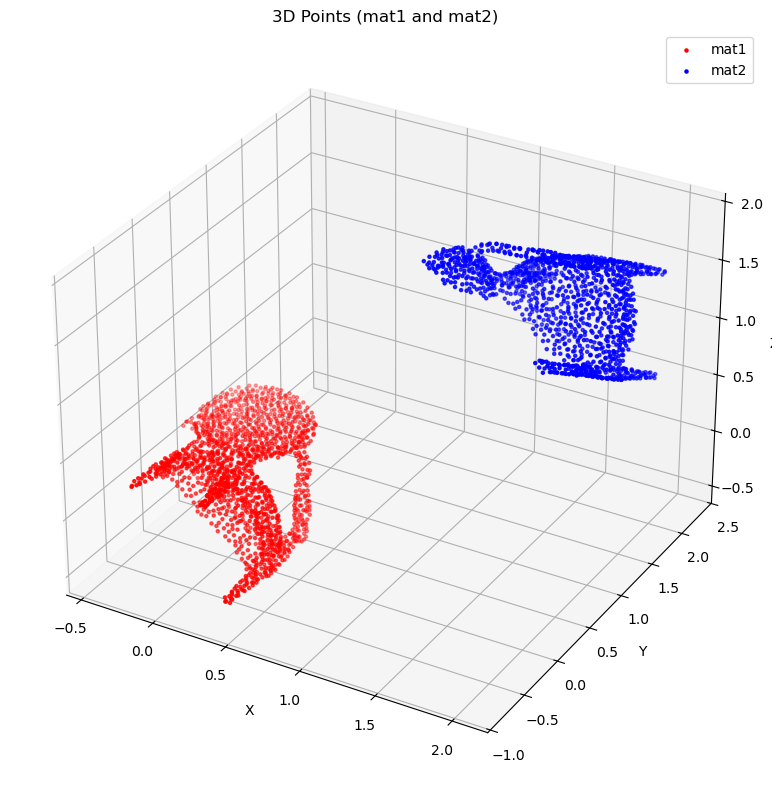

In [14]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(mat1[:, 0], mat1[:, 1], mat1[:, 2], color='red', label='mat1', s=5)

# mat2
ax.scatter(mat2[:, 0], mat2[:, 1], mat2[:, 2], color='blue', label='mat2', s=5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Points (mat1 and mat2)')
ax.legend()
plt.tight_layout()
plt.show()

In [15]:
matched_src = mat2[correspondences[:, 1]]  
matched_dst = mat1[correspondences[:, 0]]  


R, t = umeyama_alignment(matched_src, matched_dst)

mat2_aligned = ((R @ mat2.T)).T + t

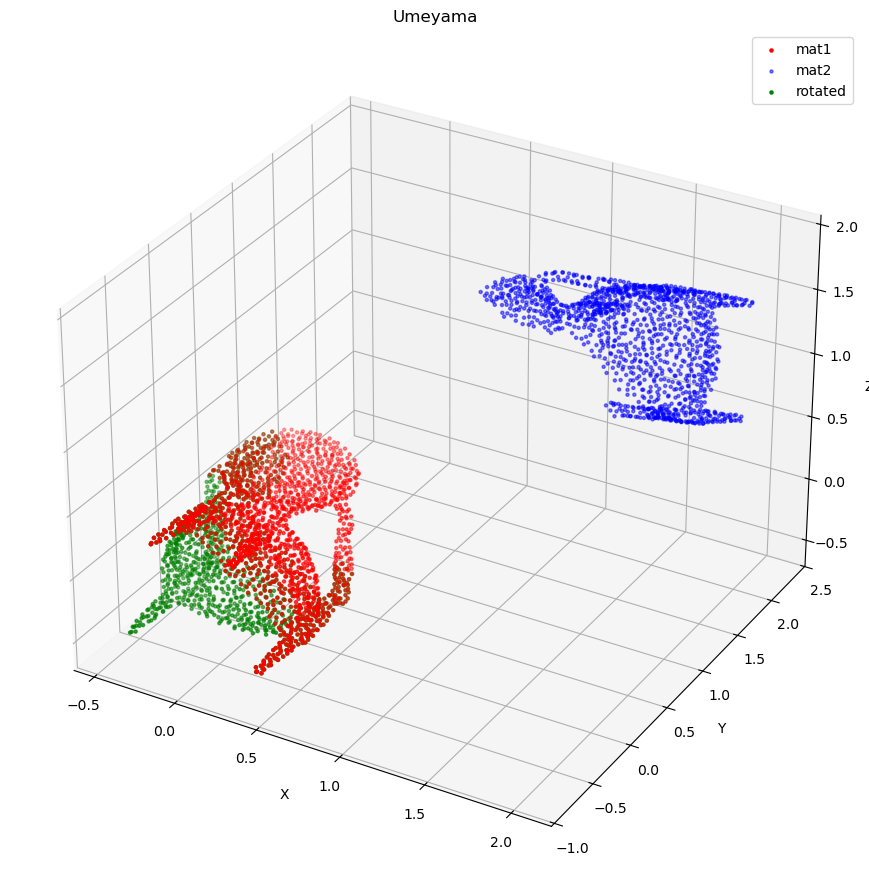

In [16]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(mat1[:, 0], mat1[:, 1], mat1[:, 2], c='red', label='mat1', s=5)
ax.scatter(mat2[:, 0], mat2[:, 1], mat2[:, 2], c='blue', label='mat2', s=5, alpha=0.5)
ax.scatter(mat2_aligned[:, 0], mat2_aligned[:, 1], mat2_aligned[:, 2], c='green', label='rotated', s=5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Umeyama')
ax.legend()
plt.tight_layout()
plt.show();

## 3)Cup

In [17]:
mat1 = np.loadtxt(dataset_path + "dataset1/cup/mat1.txt")
mat2 = np.loadtxt(dataset_path + "dataset1/cup/mat2.txt")
correspondences = np.loadtxt(dataset_path + "dataset1/cup/correspondences.txt").astype(int)

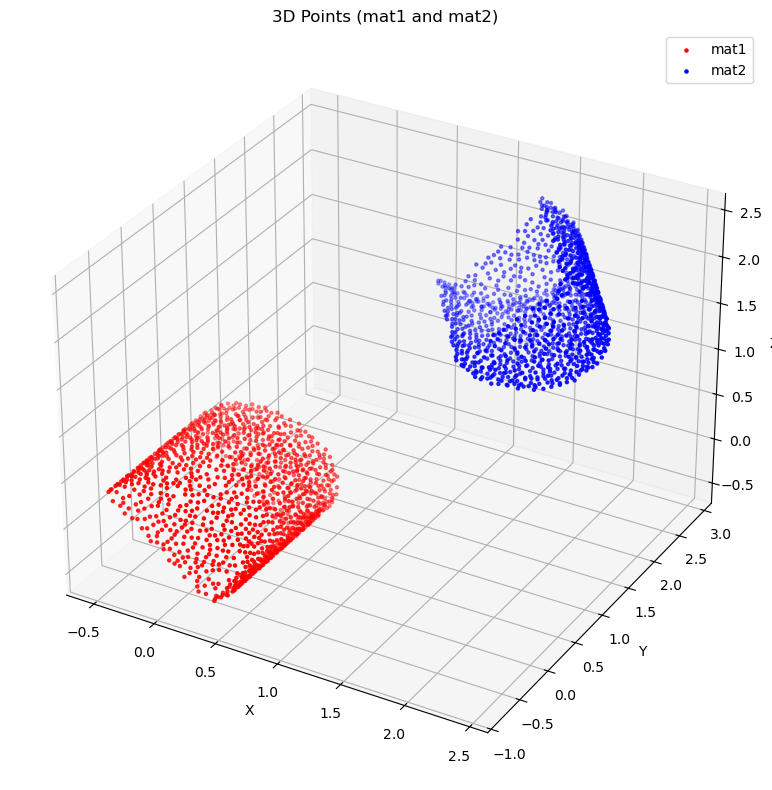

In [18]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(mat1[:, 0], mat1[:, 1], mat1[:, 2], color='red', label='mat1', s=5)

ax.scatter(mat2[:, 0], mat2[:, 1], mat2[:, 2], color='blue', label='mat2', s=5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Points (mat1 and mat2)')
ax.legend()
plt.tight_layout()
plt.show()

In [19]:
matched_src = mat2[correspondences[:, 1]]  
matched_dst = mat1[correspondences[:, 0]]  


R, t = umeyama_alignment(matched_src, matched_dst)

mat2_aligned = ((R @ mat2.T)).T + t

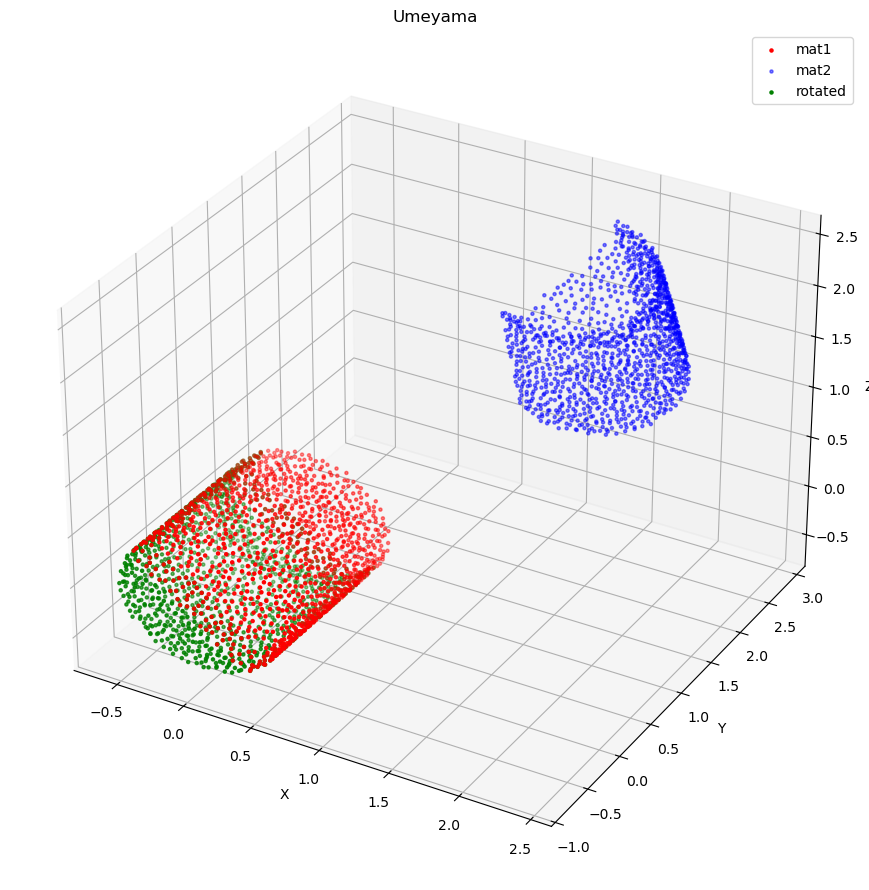

In [20]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Nokta bulutları
ax.scatter(mat1[:, 0], mat1[:, 1], mat1[:, 2], c='red', label='mat1', s=5)
ax.scatter(mat2[:, 0], mat2[:, 1], mat2[:, 2], c='blue', label='mat2', s=5, alpha=0.5)
ax.scatter(mat2_aligned[:, 0], mat2_aligned[:, 1], mat2_aligned[:, 2], c='green', label='rotated', s=5)

# Ekseni ayarla
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Umeyama')
ax.legend()
plt.tight_layout()
plt.show();

# PART B

## Functions

In [21]:
def align_and_merge_images(img1, img2, src_points, dst_points):


    # calculate R and t
    R, t = umeyama_alignment(src_points, dst_points)

    # affine transform matrix
    M = np.hstack([R, t.reshape(-1, 1)]).astype(np.float32)

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    #new shape 
    out_w = w1 * 2
    out_h = h1 * 2

    offset = np.array([[1, 0, w1 // 2],
                       [0, 1, h1 // 2]], dtype=np.float32)

    M_full = offset @ np.vstack([M, [0, 0, 1]])
    M_full = M_full[:2, :]

    img2_aligned = cv2.warpAffine(img2, M_full, (out_w, out_h))

    canvas = np.zeros((out_h, out_w, 3), dtype=np.uint8)
    x_offset = w1 // 2
    y_offset = h1 // 2
    canvas[y_offset:y_offset+h1, x_offset:x_offset+w1] = img1

    mask = (img2_aligned > 0)
    canvas[mask] = img2_aligned[mask]

    return canvas


## 1)Grid

In [22]:
img1 = cv2.imread(dataset_path + "dataset2/grid/image1.png") 
img2 = cv2.imread(dataset_path + "dataset2/grid/image2.png")

In [23]:
with open(dataset_path + "dataset2/grid/correspondences.json" , 'r') as f:
    data = json.load(f)

In [24]:
src = np.array([item["img2_xy"] for item in data])  # transformed image
dst = np.array([item["img1_xy"] for item in data])  # original image

print("Source points:\n", src)
print("Destination points:\n", dst)

Source points:
 [[ 55 235]
 [ 48  95]
 [123 164]
 [128 302]]
Destination points:
 [[200 200]
 [300 100]
 [300 200]
 [200 300]]


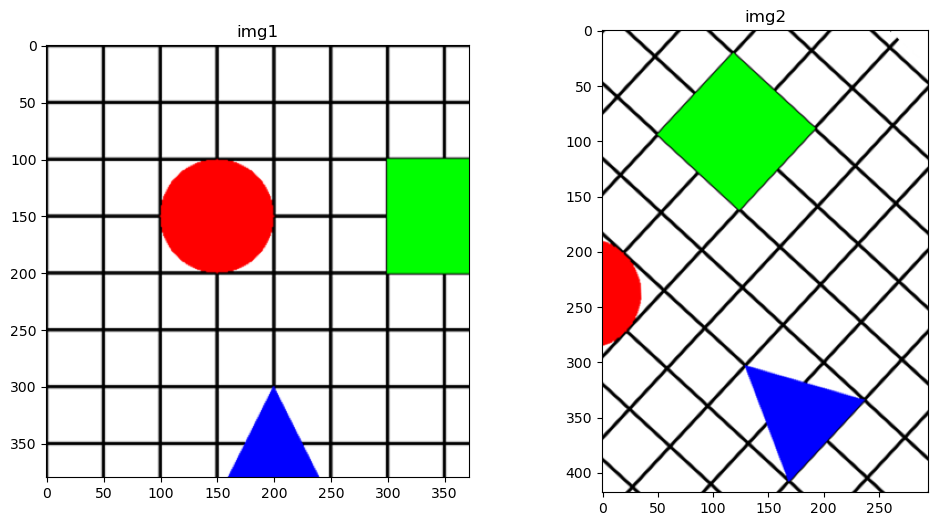

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("img1")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("img2")
plt.show()

In [26]:
R , t = umeyama_alignment(src , dst)
print("Rotation Matrix :\n" , R)
print("Transtion Matrix :\n" , t)

Rotation Matrix :
 [[ 0.67618151 -0.73673507]
 [ 0.73673507  0.67618151]]
Transtion Matrix :
 [3.36768216e+02 2.38826072e-01]


In [27]:
N = np.hstack([R , t.reshape(-1 ,1)])
h , w = img1.shape[:2]
img2_transformed = cv2.warpAffine(img2, N, (w, h))

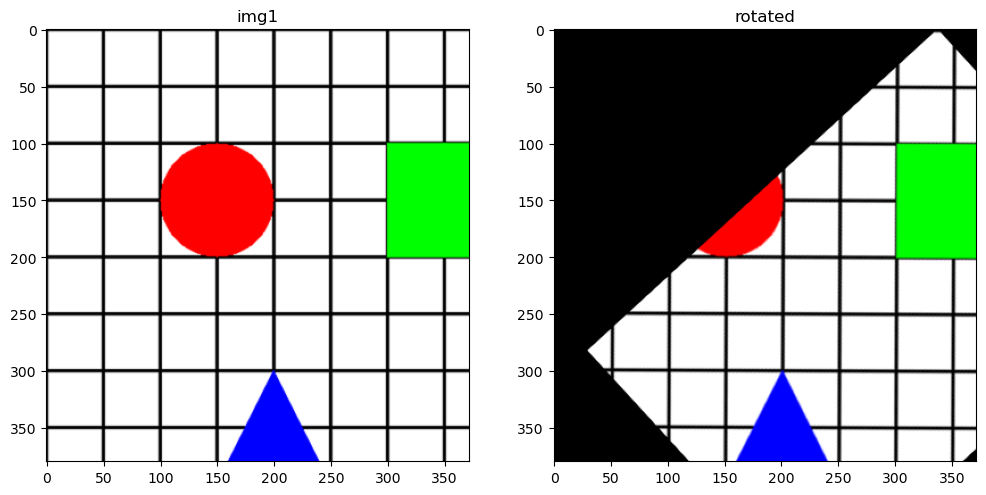

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("img1")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_transformed, cv2.COLOR_BGR2RGB))
plt.title("rotated")
plt.show()

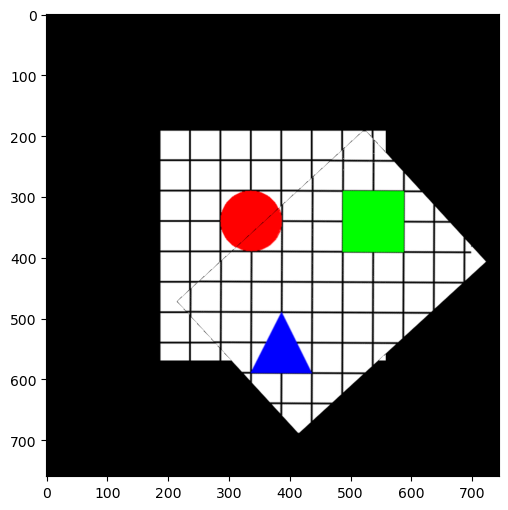

In [29]:
result = align_and_merge_images(img1, img2, src, dst)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

## 2)Mountain

In [30]:
with open(dataset_path + "dataset2/mountain/correspondences.json" , 'r') as f:
    data = json.load(f)

In [31]:
src = np.array([item["img2_xy"] for item in data])  # transformed image
dst = np.array([item["img1_xy"] for item in data])  # original image

print("Source points:\n", src)
print("Destination points:\n", dst)

Source points:
 [[256 143]
 [284 216]
 [357 328]
 [272 423]
 [ 26 383]
 [ 35 326]
 [ 31 271]]
Destination points:
 [[414 160]
 [438 235]
 [503 352]
 [412 442]
 [168 382]
 [182 326]
 [181 270]]


In [32]:
img1 = cv2.imread(dataset_path + "dataset2/mountain/image1.png") 
img2 = cv2.imread(dataset_path + "dataset2/mountain/image2.png")

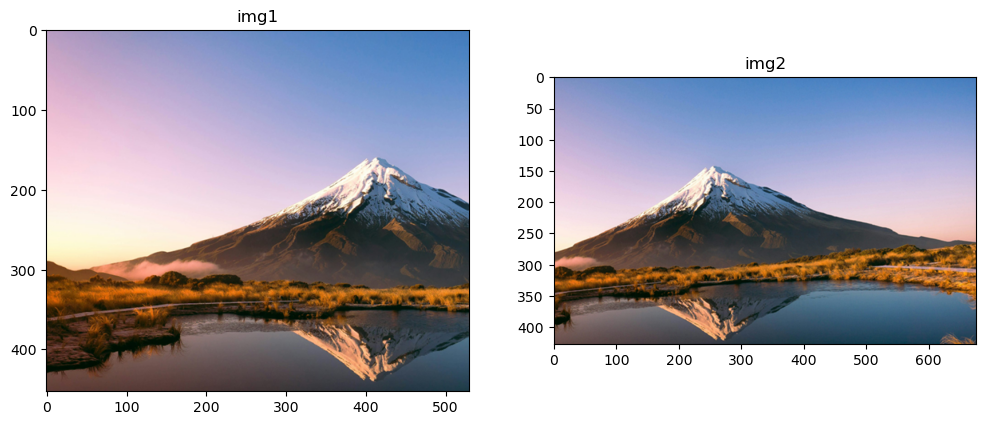

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("img1")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("img2")
plt.show()

In [34]:
R , t = umeyama_alignment(src , dst)
print("Rotation Matrix :\n" , R)
print("Transtion Matrix :\n" , t)

Rotation Matrix :
 [[ 0.99727742 -0.07374102]
 [ 0.07374102  0.99727742]]
Transtion Matrix :
 [170.65027066  -1.47103453]


In [35]:
N = np.hstack([R , t.reshape(-1 ,1)])
h , w = img1.shape[:2]
img2_transformed = cv2.warpAffine(img2, N, (w, h))

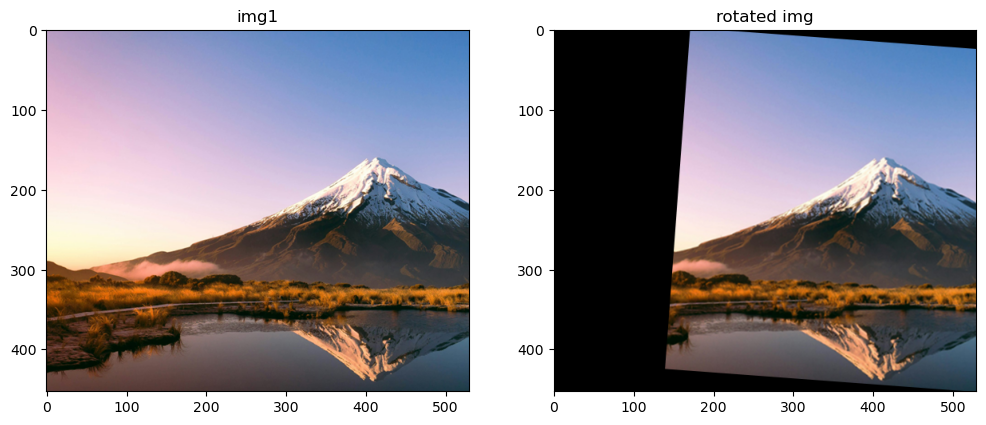

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("img1")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_transformed, cv2.COLOR_BGR2RGB))
plt.title("rotated img")
plt.show()

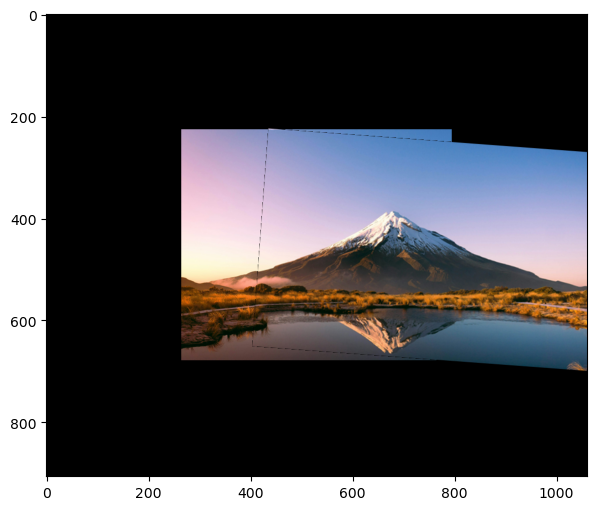

In [37]:
result = align_and_merge_images(img1, img2, src, dst)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

## 3)Pikachu

In [38]:
with open(dataset_path + "dataset2/pikachu/correspondences.json" , 'r') as f:
    data = json.load(f)

In [39]:
src = np.array([item["img2_xy"] for item in data])  # transformed image
dst = np.array([item["img1_xy"] for item in data])  # original image

print("Source points:\n", src)
print("Destination points:\n", dst)

Source points:
 [[165 146]
 [  4 216]
 [108 280]
 [150 314]]
Destination points:
 [[373 146]
 [212 216]
 [316 280]
 [358 314]]


In [40]:
img1 = cv2.imread(dataset_path + "dataset2/pikachu/image1.png") 
img2 = cv2.imread(dataset_path + "dataset2/pikachu/image2.png")

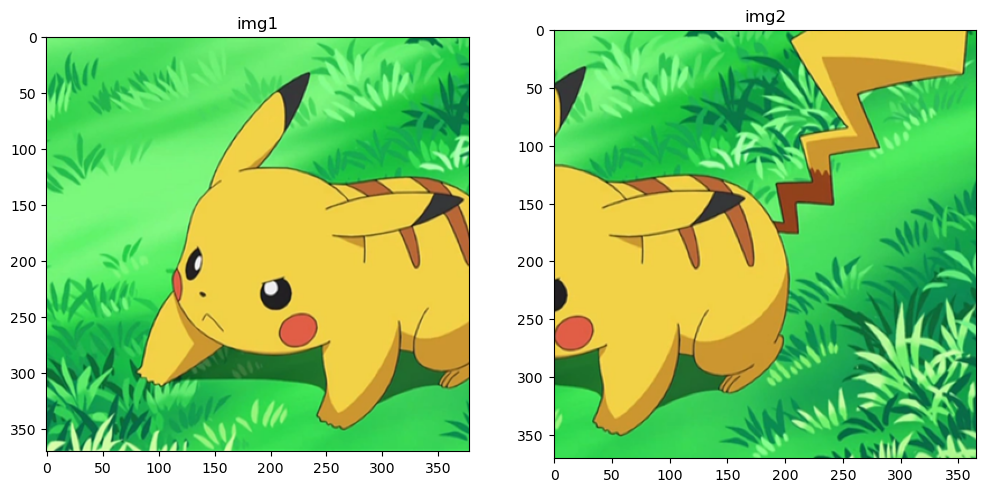

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("img1")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("img2")
plt.show()

In [42]:
R , t = umeyama_alignment(src , dst)
print("Rotation Matrix :\n" , R)
print("Transtion Matrix :\n" , t)

Rotation Matrix :
 [[1.00000000e+00 1.99656195e-16]
 [1.75128192e-16 1.00000000e+00]]
Transtion Matrix :
 [ 2.08000000e+02 -2.84217094e-13]


In [43]:
N = np.hstack([R , t.reshape(-1 ,1)])
h , w = img1.shape[:2]
img2_transformed = cv2.warpAffine(img2, N, (w, h))

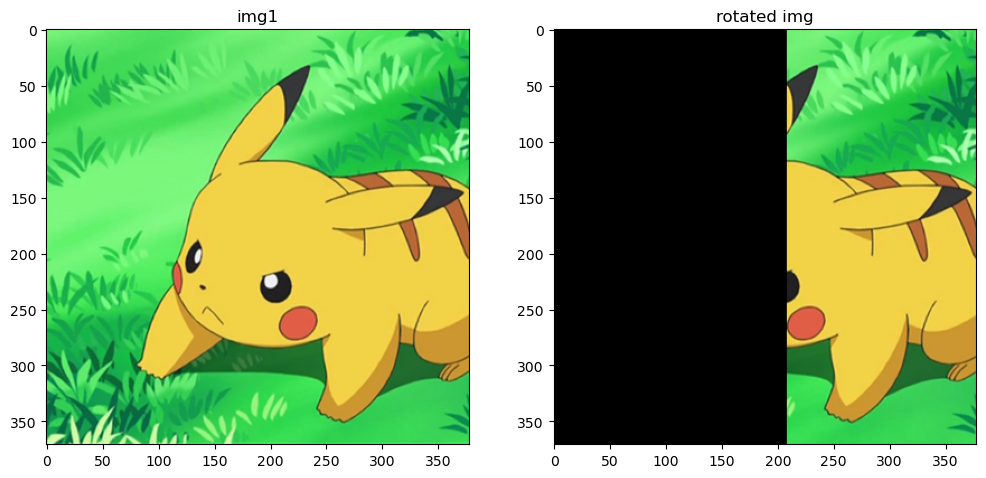

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("img1")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_transformed, cv2.COLOR_BGR2RGB))
plt.title("rotated img")
plt.show()

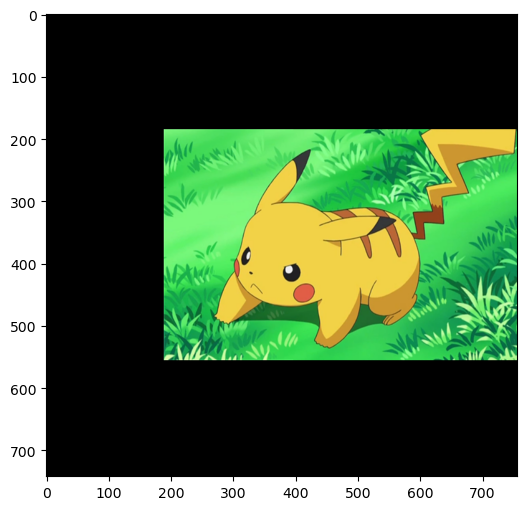

In [45]:
result = align_and_merge_images(img1, img2, src, dst)

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))